In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
from utils import *
import pickle
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch import Tensor

### Download data

In [13]:
path = 'data/mnist/'
os.makedirs(path, exist_ok=True)

URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

get_data(URL+FILENAME, path+FILENAME)

mnist.pkl.gz: 16.2MB [00:06, 2.41MB/s]                            


In [21]:
def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

### Normalize

In [22]:
mean = x.mean()
std = x.std()
x=(x-mean)/std

x_valid = (x_valid-mean)/std

### Logistic Regression in Pytorch: high level

In [64]:
net = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()
)

crit = nn.NLLLoss()
opt  = SGD(net.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)

In [66]:
inputs = Tensor(x)
labels = torch.LongTensor(y)
for epoch in range(100): 
    opt.zero_grad()
    
    outputs = net(inputs)
    loss = crit(outputs, labels)
    loss.backward()
    opt.step()
    if epoch % 10 == 9:
        print(loss.item())

0.1263873279094696
0.11693833023309708
0.10880535840988159
0.10172034054994583
0.09546114504337311
0.08988504856824875
0.08488171547651291
0.08037255704402924
0.0762910470366478
0.07258512079715729


In [43]:
def accuracy(out, labels):
  outputs = np.argmax(out, axis=1)
  return np.sum(outputs==labels)/float(labels.size)

In [67]:
accuracy(net(Tensor(x_valid)).detach().numpy(), y_valid)

0.9737

In [68]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


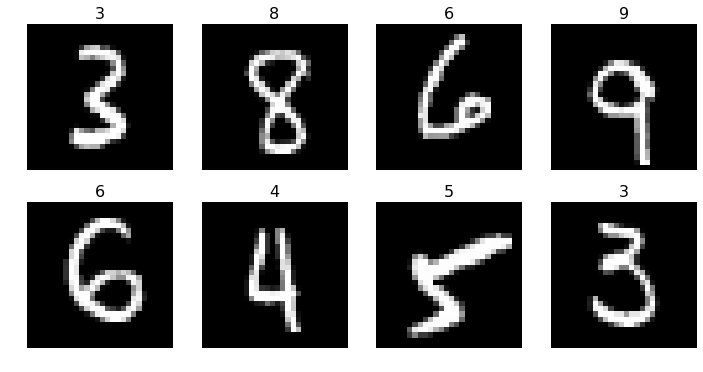

In [88]:
preds = net(Tensor(x_valid))
preds = preds.argmax(1)

x_imgs = np.reshape(x_valid, (-1,28,28))

plots(x_imgs[:8], titles= preds[:8].numpy())

### Logistic Regression in Pytorch: low level

In [89]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])
def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])

class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = (x @ self.l1_w) + self.l1_b  # Linear Layer
        x = torch.log(softmax(x)) # Non-linear (LogSoftmax) Layer
        return x

In [96]:
net2 = LogReg()
opt  = Adam(net2.parameters(),lr=0.01)

In [102]:
inputs = Tensor(x)
labels = torch.LongTensor(y)
for epoch in range(100): 
    opt.zero_grad()
    
    outputs = net2(inputs)
    loss = crit(outputs, labels)
    loss.backward()
    opt.step()
    if epoch % 10 == 9:
        print(loss.item())

0.23909537494182587
0.2384054809808731
0.23773911595344543
0.23709847033023834
0.2364807277917862
0.2358863800764084
0.2353108525276184
0.23475652933120728
0.23421715199947357
0.23369890451431274


In [103]:
accuracy(net(Tensor(x_valid)).detach().numpy(), y_valid)

0.9737

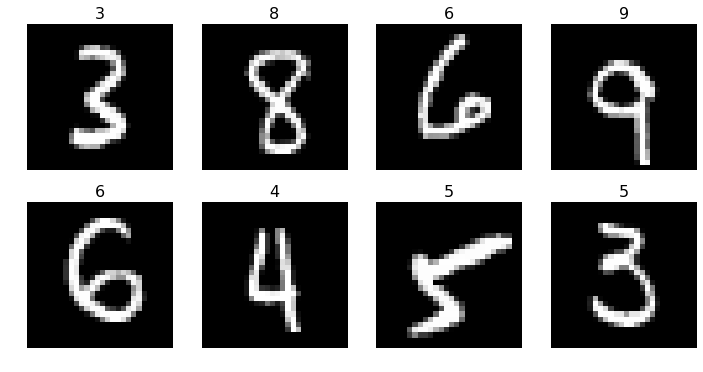

In [104]:
preds = net2(Tensor(x_valid))
preds = preds.argmax(1)

x_imgs = np.reshape(x_valid, (-1,28,28))

plots(x_imgs[:8], titles= preds[:8].numpy())